# Problem Session 4

The problems in this notebook will cover the content covered in our Regression lectures including:
- Regularization
- Principle Component Analysis
- Categorical Variables and Interactions
- Pipelines

In [41]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#### 1. Practice creating mock data and fitting models to it

Creating your own fake data and fitting models to that data is a good way to practice.  It is nice because you have access to the "ground truth" when you make your own data.

Another more practical usage of simulation is parametric bootstrapping, which we will cover in a few lectures.

It is also *very common* to need to mock up some data during an interview.
##### a.

Use `np.linspace` to create an array of `100` equally spaced values between $0$ and $5$.  Store this in a variable called `x`.

Simulate $$y = x + x^2 + \epsilon \textrm{ where }\epsilon \sim \mathcal{N}(\mu = 0,\sigma = 10)$$ using `np.random.randn`.  Store this in a variable called `y`.

##### Sample Solution

In [42]:
nobs = 100
x = np.linspace(0,5, num = nobs)

y = x + x**2  + 10*np.random.randn(nobs)

##### b.

Make a scatterplot of $y$ against $x$ using `plt`.  Also plot the "ground truth" relationship. 

##### Sample Solution

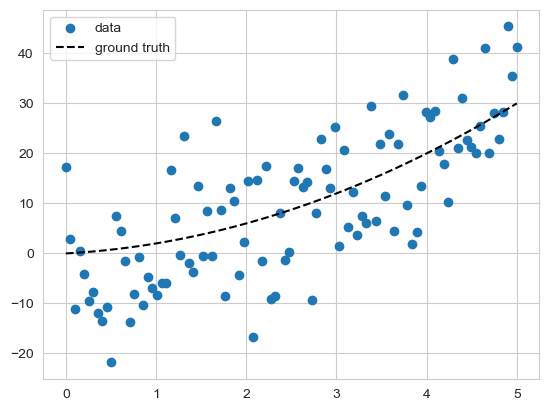

In [43]:
plt.scatter(x,y, label = 'data')
plt.plot(x, x + x**2, '--k', label = 'ground truth')
plt.legend()
plt.show()

##### c.

Fit three different models to this data:

1. The OLS fit of a degree 10 polynomial.
2. The ridge regression fit of a degree 10 polynomial using the default `alpha = 1`.  Be sure to use StandardScaler as the first step in the pipeline!
3. A pipeline using PCA:  scale -> polynomial transform of degree 10 -> PCA with 5 components -> OLS linear regression.

In each case we are fitting a degree 10 polynomial which should **over-fit**.  Our hope is that regularization using either Ridge or PCA will tame that a bit.

##### Sample Solution

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA

In [45]:
pipe_ols = Pipeline([('poly', PolynomialFeatures(degree=10)), ('ols', LinearRegression())])
pipe_ridge = Pipeline([('scale', StandardScaler()),('poly', PolynomialFeatures(degree=10)), ('ridge', Ridge(alpha = 1))])
pipe_pca = Pipeline([('scale', StandardScaler()),('poly', PolynomialFeatures(degree=10)), ('pca', PCA(5)), ('ols', LinearRegression())])

pipe_ols.fit(x.reshape(-1,1),y)
pipe_ridge.fit(x.reshape(-1,1),y)
pipe_pca.fit(x.reshape(-1,1),y)


Pipeline(steps=[('scale', StandardScaler()),
                ('poly', PolynomialFeatures(degree=10)),
                ('pca', PCA(n_components=5)), ('ols', LinearRegression())])

##### d.

Graph all 3 fit models together with the ground truth.  Which is the best approximation of the ground truth?

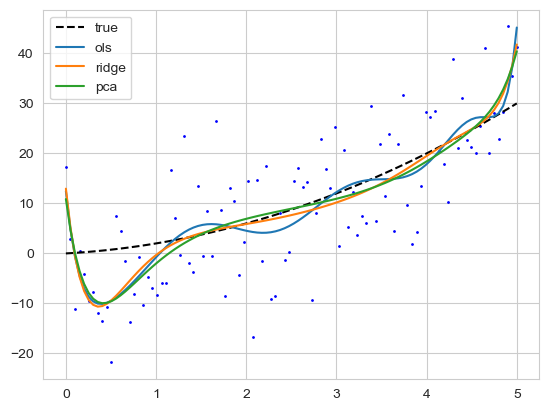

In [46]:
plt.scatter(x,y, c = 'b', s = 1)
plt.plot(x, x + x**2,'--k',label = 'true')
plt.plot(x, pipe_ols.predict(x.reshape(-1,1)), label = 'ols')
plt.plot(x, pipe_ridge.predict(x.reshape(-1,1)), label = 'ridge')
plt.plot(x, pipe_pca.predict(x.reshape(-1,1)), label = 'pca')

plt.legend()
plt.show()

You may want to rerun all cells above this one a few times to see the variation in fitted models.

In [47]:
# Click "Execute above cells" a few times to see the variation. 

Even if you only managed to get through this section it is a profitable use of a problem session!  Depending on the speed of your group you may be able to also tackle the next section.  If not, treat it as homework!

#### 2. The diamonds dataset

We introduce a new "classic" dataset.  Our task is to predict the price of diamonds.

* price: Price in US dollars.
* carat: Weight of the diamond.
* cut: Cut quality (ordered worst to best).
* color: Color of the diamond (ordered best to worst).
* clarity: Clarity of the diamond (ordered worst to best).
* x: Length in mm.
* y: Width in mm.
* z: Depth in mm.
* depth: Total depth percentage: 100 * z / mean(x, y)
* table: Width of the top of the diamond relative to the widest point.

Homepage: https://ggplot2.tidyverse.org/reference/diamonds.html

In [48]:
df = pd.read_csv('../../data/diamonds.csv')

In [49]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


For sake of time we will restrict ourselves to just one categorical feature (`cut`) and one continuous feature (`carat`) in our modeling.  This is only being done for pedagogical purposes!  In a real situation you would want to carefully explore all of the data you have available.

In [50]:
df = df[['cut', 'carat', 'price']]

#### a.

### Sample Solution

In [51]:
# Make a train/test split with 20% of data held aside as the test set.
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=216)

X_train = df_train[['cut', 'carat']]
X_test = df_test[['cut', 'carat']]
y_train = df_train.price
y_test = df_test.price

##### b. 

What are the percentage of samples belonging to each level of the `cut` feature?

### Sample Solution

In [52]:
100*X_train.cut.value_counts()/X_train.shape[0]

cut
Ideal        39.859103
Premium      25.583982
Very Good    22.548202
Good          9.023915
Fair          2.984798
Name: count, dtype: float64

##### c. 

Look at the distribution of price at each level of the `cut` feature.  Do you notice anything strange or unexpected?

### Sample Solution

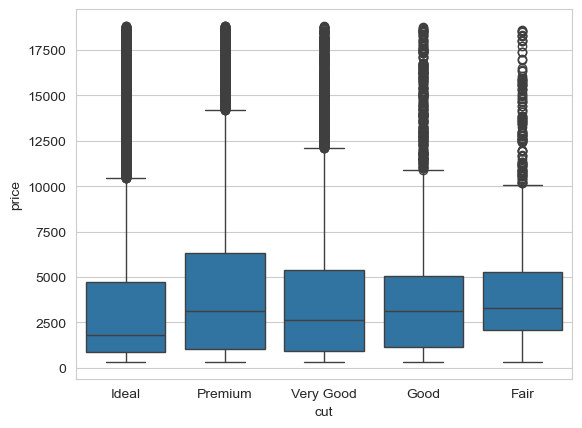

In [53]:
sns.boxplot(data=df_train, x = 'cut', y='price')
plt.show()

##### d. 

One thing which might be a bit confusing is that the cut quality does not seem to be a very good indicator of price.  Why might that be?

Sometimes this happens when two predictors which each have a positive **causal** impact on the outcome are negatively correlated with each other.  In other words, it might be that **all else being equal** a higher quality cut will increase the price, and a larger carat will increase the price, but higher quality cuts are negatively correlated with the size in carats.

Use the `groupby` and `describe` methods to look at some summary statistics of carat size sorted by cut quality.

### Sample Solution

In [54]:
df_train.groupby('cut').carat.describe().loc[['Ideal', 'Premium','Very Good','Good','Fair']]

,count,mean,std,min,25%,50%,75%,max
cut,,,,,,,,
Ideal,17200.0,0.703963,0.433304,0.20,0.35,0.54,1.01,3.50
Premium,11040.0,0.892583,0.516738,0.20,0.41,0.83,1.20,4.01
Very Good,9730.0,0.806934,0.457980,0.20,0.41,0.72,1.02,4.00
Good,3894.0,0.852424,0.451219,0.23,0.50,0.90,1.01,3.01
Fair,1288.0,1.051607,0.521006,0.22,0.70,1.00,1.20,5.01


We can see that the "Fair" quality also has the largest mean carat size, while "Ideal" quality has the smallest. I am not a domain expert, but this could be due to jewelers needing to cut away more of the original stone to produce better cuts?  This would be something to consult with a jeweler on.

##### e.

Graph price against carat with color coded by cut quality.

### Sample Solution

In [76]:
sns.color_palette(palette=None)[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

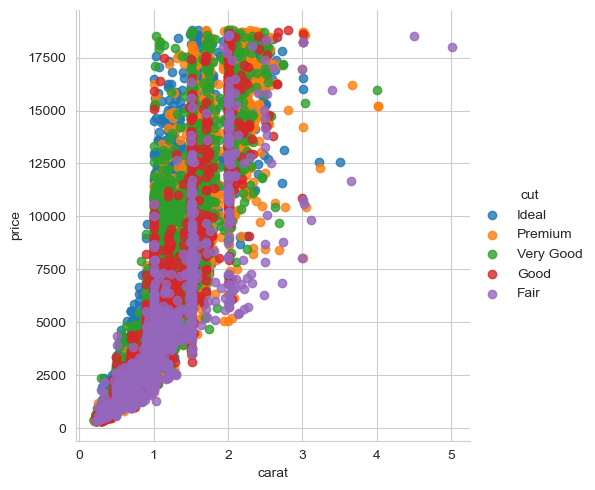

In [55]:
sns.lmplot(data = df_train, x = 'carat', y = 'price', hue = 'cut', fit_reg=False)
plt.show()

##### f.

The relationship you obtained above does not look linear.  Graph the log of the price against the log of the carat size.  This should look substantially more linear!

### Sample Solution

In [56]:
df_train['log_price'] = np.log(df_train['price'])
df_train['log_carat'] = np.log(df_train.carat)

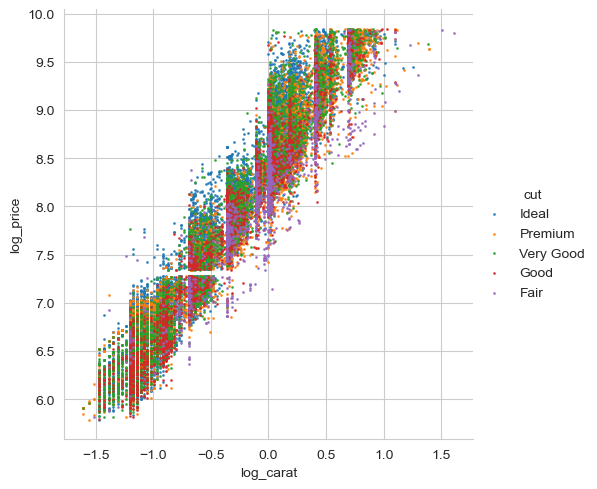

In [89]:
sns.lmplot(data = df_train, x= 'log_carat', y = 'log_price', hue = 'cut', fit_reg = False, scatter_kws={'s':1})
plt.show()

##### g.

We do not have the ability to **experimentally** adjust `cut` and `carat` independently to see the impact on price, but we can still use **statistical control**.

We will run a linear regression of `log_price` against `cut` and `log_carat`.  Do better cuts contribute to higher prices when controlling for carat?

In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression

In [59]:
# Discuss what you think preprocessor does with your team.  Can you test that it does what you think it should?
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), ['cut']),
        ('identity', FunctionTransformer(func = None), ['log_carat'])
        ])

# Write a pipeline which first uses preprocessor and then uses LinearRegression(fit_intercept = False). 
# Why do I not want to fit the intercept term?
model = Pipeline([('preprocess', preprocessor),('linear', LinearRegression(fit_intercept = False))])

# Fit it on the training set using the 'cut' and 'log_carat'features (in that order).
model.fit(df_train[['cut','log_carat']], df_train.log_price)

# It is a bit difficult to access the feature names of one part of a pipeline, so I have done it for you.
feature_names = model['preprocess'].transformers_[0][1].get_feature_names_out()

cut_adjustments = {feature_name: float(model['linear'].coef_[i]) for i,feature_name in enumerate(feature_names)}

cut_adjustments_sorted = dict(sorted(cut_adjustments.items(), key=lambda item: item[1]))

cut_adjustments_sorted

{'cut_Fair': 8.199858555480068,
 'cut_Good': 8.365143083404948,
 'cut_Premium': 8.437941267704483,
 'cut_Very Good': 8.440568480455788,
 'cut_Ideal': 8.519414885022087}

#### h. Evaluating residuals

Make a plot of residuals against predicted values.  Discuss the implications for your model.

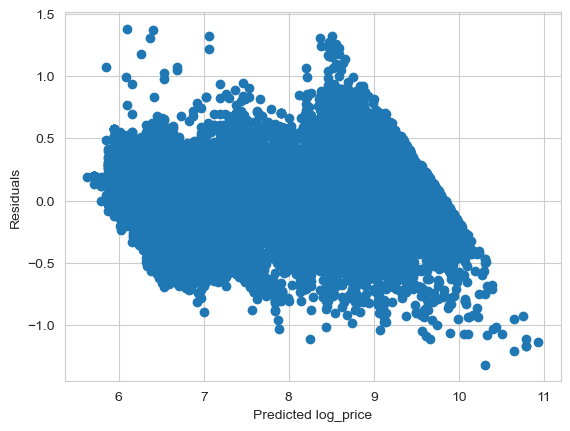

In [60]:
preds = model.predict(df_train[['cut','log_carat']])
residuals = df_train['log_price'] - preds
plt.scatter(preds, residuals)

plt.xlabel('Predicted log_price')
plt.ylabel('Residuals')

plt.show()

The lines in the residual plot are due to the apparent thresholds on price in the training data.  Prices seem to have a soft cap at around $18k and a soft minimum of around $350.

#### i. Quantifying model performance

Let's use [mean absolute percentage error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) and [mean absolute error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as our performance metrics.  How does our model perform on the training set?

### Sample Solution

In [62]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [63]:
print(f" The mean absolute percentage error is {100*mean_absolute_percentage_error(y_true = df_train.price, y_pred= np.exp(preds)): .1f}%")
print(f" The mean absolute error is ${mean_absolute_error(y_true = df_train.price, y_pred= np.exp(preds)): .1f}")

 The mean absolute percentage error is  20.2%
 The mean absolute error is $ 822.2
